## Cardiovascular Risk Prediction in the Male Swiss Population: A Predictive Analysis of Diagnosis Levels

## Introduction

Bckground: Coronary diseases pose significant health challenges, requiring precise predictive models. In Switzerland, understanding diagnostic factors, particularly among males, is crucial. Utilizing a discriminant function model dataset, this study focuses on the relationship between age, maximum heart rate, and male diagnosis levels in Switzerland. The unique healthcare landscape and lifestyle factors make this exploration essential for tailored interventions and improved cardiovascular risk assessment in the Swiss male population.
Predictive question: How do age and maximum heart rate as predictor variables influence the likelihood of heart disease diagnosis in males within the Swiss population?
Dataset: The dataset for this analysis is derived from a discriminant function model, initially developed using clinical and noninvasive test results from 303 patients undergoing angiography at the Cleveland Clinic. Subsequently applied to diverse patient groups, including 143 patients from University Hospitals in Zurich and Basel, Switzerland, the dataset encompasses variables such as age, sex, chest pain, resting blood pressure, cholesterol levels,  maximum heart rate and other relevant features for predicting male diagnosis levels in the Swiss context.

## Prelim Analysis

In [7]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

In [8]:
# downloading and reading data, naming columns
url <- "https://raw.githubusercontent.com/ssun05/dsci_100_002_group5_project/main/processed.cleveland.data"
#download.file(url, "heart_data.csv")
heart_data <- read_csv("heart_data.csv", col_names = c("age", "sex", "chest_pain", "trestbps", "chol", "fasting_bld_sgar",
                                                      "restecg", "max_heart_rate", "exerc_angina", "oldpeak", "slope", "ca", "thal", "diagnosis"))

heart_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, chest_pain, trestbps, chol, fasting_bld_sgar, restecg, m...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,chest_pain,trestbps,chol,fasting_bld_sgar,restecg,max_heart_rate,exerc_angina,oldpeak,slope,ca,thal,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


In [9]:
# filter for males and reclass diagnosis as factor, make labels understandable
heart_data_renamed <- heart_data |> 
                    mutate(diagnosis = as_factor(diagnosis)) |>
                    mutate(diagnosis = fct_recode(diagnosis, "none" = "0", "yes" = "1", "yes" = "2", "yes" = "3", "yes" = "4"))

heart_data_renamed

age,sex,chest_pain,trestbps,chol,fasting_bld_sgar,restecg,max_heart_rate,exerc_angina,oldpeak,slope,ca,thal,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,none
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,yes
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,yes
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,yes
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,yes
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,none


In [10]:
heart_split <- initial_split(heart_data_renamed, prop = 0.75, strata = diagnosis)

heart_train <- training(heart_split)
heart_test <- testing(heart_split)

In [11]:
# table of diagnosis counts
label_counts <- heart_train |>
                group_by(diagnosis) |>
                summarize(count = n())
label_counts

diagnosis,count
<fct>,<int>
none,123
yes,104


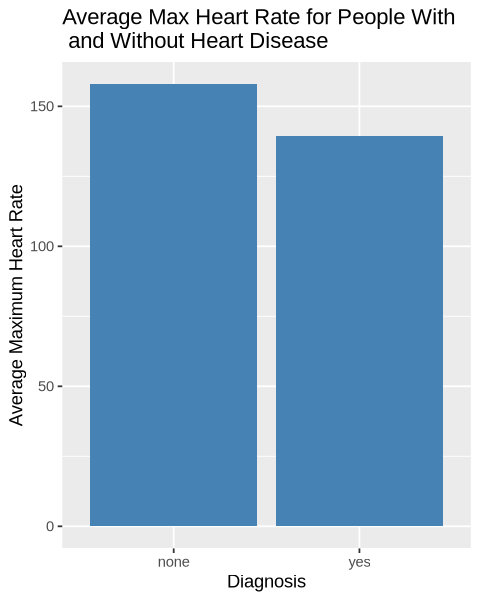

In [24]:
mean_max_hrt_rate <- heart_train |>
                        group_by(diagnosis) |>
                        summarize(mean_heart = mean(max_heart_rate))

# mean_max_hrt_rate

options(repr.plot.width = 4, repr.plot.height = 5)
avg_hrt_plot <- mean_max_hrt_rate |> 
                ggplot(aes(x = diagnosis, y = mean_heart)) +
                geom_bar(stat = "identity", fill = "steelblue") +
                labs(x = "Diagnosis", y = "Average Maximum Heart Rate") +
                ggtitle("Average Max Heart Rate for People With \n and Without Heart Disease")

avg_hrt_plot

## Methods

This analysis will use an knn classification method in order to answer the research question. With this method we will use the variables of age and max_heart_rate as predictor variables and use diagnosis as the classifier variable. After repeated testing we have found that age and max heart rate allows for the most predictive power in this application. 

We decided to use knn classification as opposed to knn regression due to the nature of the question that we are trying to answer. Diagnosis takes on values from 0 - 4 which at first looks quantitative but it is more categorical in nature because each value represents a distinct category in which heart disease can be grouped in. In order to make this distinction more clear we decided to categorize these values into two: "no" (0) and "yes" (1 - 4) which simply indicates the presence of heart disease or not.

We will perform an analysis in order to determine the best K value that maximizes our recall. If there is a person with heart disease out there we want to be sure that they get identified. We want to minimize the amount of false negatives.

Finally to build our classifier we will create an workflow that contains an recipe, that scales and centers all predictors, and a model.

To visualize our results we will use a confusion matrix that summarizes the predictions that our classifier has made.

## Expected Outcomes and Significance